In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_processing import process_strain_data, process_strain_data_2d
from utils import map_point_between_ranges
import plotly.graph_objs as go
import pandas as pd
from io import StringIO
from example_read_rms import read_h5
from utils import generate_timestamps
import os
from scipy.stats import norm
 

: 

In [ ]:
# slfredri code
path = r'\\markov.math.ntnu.no\work\slfredri\20210831\Chs03400_04600'
filepaths = os.listdir(r'\\markov.math.ntnu.no\work\slfredri\20210831\Chs03400_04600')
filepaths = [path+'/'+p for p in filepaths]

filepaths2 = filepaths[1:3]


In [ ]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.models.measurement.linear import LinearGaussian

# Define a transition model with some noise
q = 1.0
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q)])

dx = 4.085200763098726
FOV = [dx*970, dx*1020]
global_clutter_rate = 1
clutter_area = FOV
r = 15
prob_detect = 0.95
clutter_spatial_density = global_clutter_rate / (FOV[1]-FOV[0])

measurement_model = LinearGaussian(
    ndim_state=2,
    mapping=(0,),
    noise_covar=np.array([[r]])
    )




In [ ]:
pi_0_1 = 0.8928571428571429
pi_0_2 = 0.10714285714285714
alpha_1 = -8.853735880931541
alpha_2 = -7.582501952718691
r_1 = 0.38245847340591643
r_2 = 0.4716636871029011
phi_1 = norm(loc=alpha_1, scale= r_1)
phi_2 = norm(loc=alpha_2, scale= r_2)

#update_thres=8

In [ ]:
from CustomDeleter import CustomDeleter
deleter = CustomDeleter(covar_trace_thresh=150, fov = FOV)

from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser_initiator = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
data_associator_initiator = GNNWith2DAssignment(hypothesiser_initiator)

from stonesoup.types.state import GaussianState
from CustomInitiator import RestrictedInitiator

initiator = RestrictedInitiator(
    prior_state = None,
    measurement_model=measurement_model,
    deleter=deleter,
    data_associator=data_associator_initiator,
    updater=updater,
    min_points=3,
    FOV = FOV,
    range = 60
    )

from stonesoup.hypothesiser.probability import PDAHypothesiser
from stonesoup.dataassociator.probability import JPDA
from tracker import JPDAtracker
hypothesiser = PDAHypothesiser(
    predictor=predictor,
    updater=updater,
    clutter_spatial_density=clutter_spatial_density,
    prob_detect=prob_detect
 
)

data_associator = JPDA(hypothesiser=hypothesiser)



tracker = JPDAtracker(
    updater = updater,
    data_associator = data_associator,
    initiator = initiator,
    deleter = deleter
)

In [ ]:
from tqdm import tqdm
from utils import create_track_dataframe
from tracker import create_measurements
#plot settings
vmin_rms, vmax_rms = -10.5, None
plot_log=1; log_thres=1e-12
# Hyperparameters
window_size=25 # Moving average smoothing window size
min_amplitude=-8.8 # Strain threshold: everything below this will not be picked 
eps=0.01 # Epsilon in DBSCAN. 

def track_fullday(filepaths, update_thres):
    DFs = []
    amps = []
    amps_all = []
    for idx in tqdm(range(len(filepaths)), desc="Processing", unit="batch"):

        try: 
            #print(filepath)
            list_data, info = read_h5(filepaths[idx], labels_group=("rms","gaps"), labels_data=("rms",), verbose=False)
            rms = list_data[0]
            rms_plot = np.log10(rms+log_thres)
            dt_rms = info["rms"]["dt_rms"]  # temporal sampling interval of rms data
            time_utc = info["gen"]["time_utc"]  # time of first sample 
            times = generate_timestamps(time_utc, dt_rms, rms.shape[0])
            dx = info["gen"]["dx"]
            chmin_rel, chmax_rel = [info["gen"][label] for label in ["chmin_rel","chmax_rel"]] # relative channel limits 
            channels_rel = np.arange(chmin_rel,chmax_rel+1)

            rms_processed = process_strain_data_2d(
            rms_plot, 
            window_size=window_size, 
            min_amplitude=min_amplitude,
            eps=eps
            )
            amps.append(rms_processed[rms_processed != 0])
            amps_all.append(rms_plot[rms_plot != 0])
            all_measurements = create_measurements(times, rms_processed, measurement_model, dx, chmin_rel, chmax_rel)

            tracker = JPDAtracker(
            updater = updater,
            data_associator = data_associator,
            initiator = initiator,
            deleter = deleter
            )

            all_tracks = tracker.track(
                all_measurements,
                times[0],
                dt=dt_rms, 
                rms_processed=rms_processed, 
                phi_1=phi_1, 
                phi_2=phi_2, 
                pi_0_1=pi_0_1, 
                pi_0_2=pi_0_2
                )

            df = create_track_dataframe(all_tracks, tracker, update_thres=update_thres)
            DFs.append(df)
        except:
            print(f"couldn't read file: {filepath}")
    
    return pd.concat(DFs,axis=0,ignore_index=True), amps, amps_all
        

In [ ]:
#DF, amps, amps_all = track_fullday(filepaths=filepaths, update_thres=5)


Processing: 100%|██████████| 149/149 [16:59<00:00,  6.84s/batch]


In [ ]:
#amps_list = np.concatenate(amps)
amps_all_list = np.concatenate(amps_all)

In [ ]:
amps_all_list = np.random.choice(amps_all_list, size=2000000, replace=False)

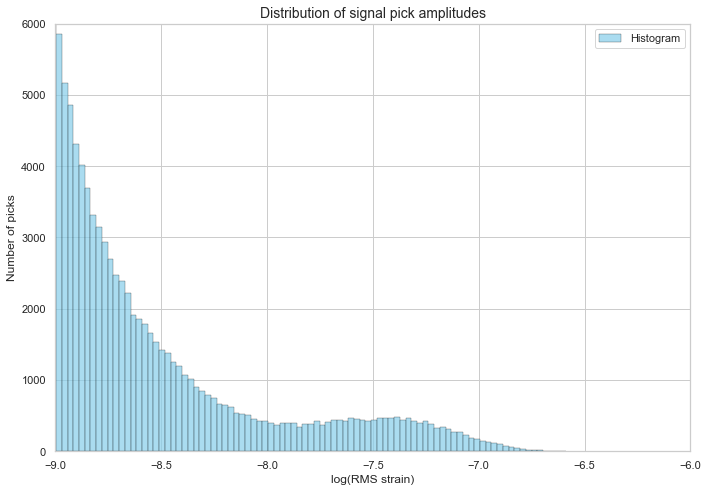

In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))
# Create a histogram using Seaborn
sns.histplot(amps_all_list, bins=200, kde=False, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
#x = np.linspace(-9,-6,1000)
# Add labels and title
#plt.axvline(x=alpha_1, color='red', linestyle='--', linewidth=2, label='alpha_1')
#plt.axvline(x=alpha_2, color='green', linestyle='--', linewidth=2, label='alpha_2')
#plt.axvline(x=min_amplitude, color='red', linestyle='-', linewidth=2, label='amplitude threshold')
#plt.plot(x, 1000*norm.pdf(x,alpha_1,np.sqrt(r_1)))
#plt.plot(x, 1000*norm.pdf(x, alpha_2, np.sqrt(r_2)))
plt.xlabel('log(RMS strain)', fontsize=12)
plt.ylabel('Number of picks', fontsize=12)
plt.title('Distribution of signal pick amplitudes', fontsize=14)
plt.xlim(-9,-6)
plt.ylim(0,6000)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()


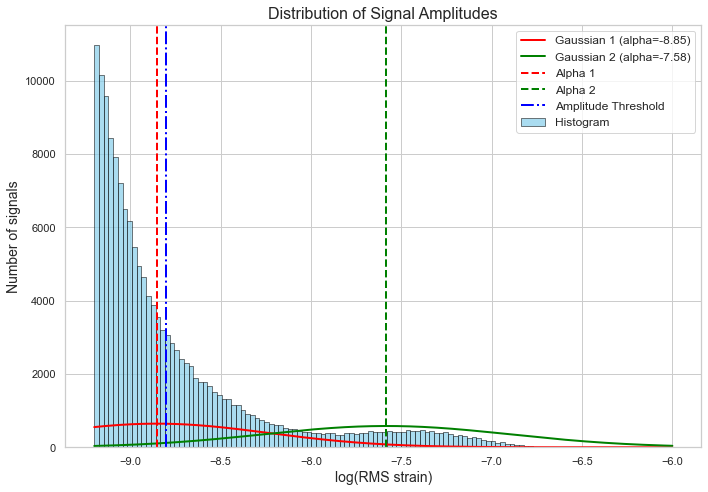

In [ ]:

sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# Create a histogram using Seaborn
sns.histplot(amps_all_list[amps_all_list>-9.2], bins=100, kde=False, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

# Generate x values for Gaussian curves
x = np.linspace(-9.2, -6, 1000)

# Plot Gaussian distributions with increased scale for visibility
scale_factor = 1000
plt.plot(x, scale_factor * norm.pdf(x, alpha_1, np.sqrt(r_1)), color='red', linestyle='-', linewidth=2, label=f'Gaussian 1 (alpha={alpha_1:.2f})')
plt.plot(x, scale_factor * norm.pdf(x, alpha_2, np.sqrt(r_2)), color='green', linestyle='-', linewidth=2, label=f'Gaussian 2 (alpha={alpha_2:.2f})')

# Add vertical lines and annotations
plt.axvline(x=alpha_1, color='red', linestyle='--', linewidth=2, label='Alpha 1')
plt.axvline(x=alpha_2, color='green', linestyle='--', linewidth=2, label='Alpha 2')
plt.axvline(x=min_amplitude, color='blue', linestyle='-.', linewidth=2, label='Amplitude Threshold')

# Add labels, title, and legend
plt.xlabel('log(RMS strain)', fontsize=14)
plt.ylabel('Number of signals', fontsize=14)
plt.title('Distribution of Signal Amplitudes', fontsize=16)
plt.legend(fontsize=12, loc='upper right')

# Adjust the axis limits if needed
#plt.xlim(-9, -6)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.grid(True)
plt.show()


In [ ]:
from datetime import datetime, timedelta
timestamp_str = '2021-08-30T23:57:25'

DF = pd.read_csv('fullday_5.csv')


DF['timestamp'] = pd.to_datetime(DF['timestamp'])

starttime = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S')
half_hour_intervals = 48
half_hour_steps = [starttime + timedelta(minutes=i*30) for i in range(half_hour_intervals)]

def get_half_hour_interval(timestamp):
    for i, step in enumerate(half_hour_steps):
        if timestamp < step:
            return i + 1  # Return the index (1-indexed) of the half-hour interval

# Create a new column 'half_hour_interval' based on the 'timestamp' column
DF['half_hour_interval'] = DF['timestamp'].apply(get_half_hour_interval)

In [ ]:
timestamp_to_interval = {}

# Populate the dictionary
for i, timestamp in enumerate(half_hour_steps):
    # Convert the timestamp to the format '%H:%M' for better representation
    formatted_timestamp = timestamp.strftime('%H:%M')
    # Assign the half-hour interval (starting from 0) as the value for the timestamp key in the dictionary
    timestamp_to_interval[i+1] = formatted_timestamp


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

import numpy as np

# Function to classify tracks based on average probabilities
def classify_track(track_df):
    avg_prob = track_df['car probability'].tail(5).mean()
    
    if np.isnan(avg_prob):
        return 'unknown'
    elif avg_prob >= 0.5:
        return 'car'
    else:
        return 'train'

# Calculate the classification for each 'track ID'
track_classifications = DF.groupby('track ID').apply(classify_track).reset_index(name='track_type')

# Merge the classification back to the original DataFrame
DF = pd.merge(DF, track_classifications, on='track ID')






In [ ]:
grouped_DF = DF.groupby(['half_hour_interval', 'track ID', 'track_type']).agg({'velocity [km/h]': 'mean'}).reset_index()

In [ ]:
grouped_DF['avg velocity south'] = grouped_DF[grouped_DF['velocity [km/h]'] >= 0].groupby(['half_hour_interval', 'track_type'])['velocity [km/h]'].transform('mean')
grouped_DF['avg velocity north'] = grouped_DF[grouped_DF['velocity [km/h]'] < 0].groupby(['half_hour_interval', 'track_type'])['velocity [km/h]'].transform('mean')
vel_DF = grouped_DF.drop(['track ID','velocity [km/h]'],axis=1).drop_duplicates()

In [ ]:
vel_agg_DF = vel_DF.groupby(['half_hour_interval', 'track_type']).apply(lambda x: x.ffill().bfill()).reset_index(drop=True)

# Drop duplicates to keep only unique rows per 'half_hour_interval' and 'track_type'
vel_agg_DF = vel_agg_DF.drop_duplicates(subset=['half_hour_interval', 'track_type'])
vel_agg_DF['timestamp'] = vel_agg_DF['half_hour_interval'].map(timestamp_to_interval)


C:\Users\simon\AppData\Local\Temp/ipykernel_24412/3449375558.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  vel_agg_DF = vel_DF.groupby(['half_hour_interval', 'track_type']).apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


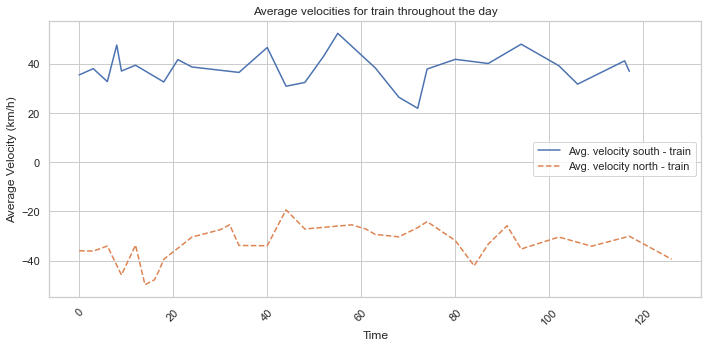

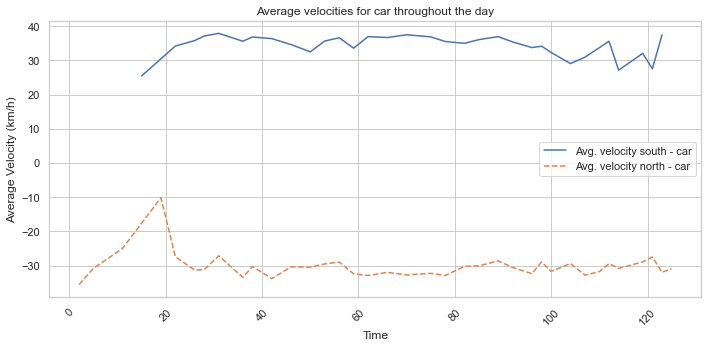

In [ ]:
#vel_agg_DF.set_index('timestamp', inplace=True)

sns.set(style="whitegrid")

# Plotting
for track_type in vel_agg_DF['track_type'].unique():
    subset = vel_agg_DF[vel_agg_DF['track_type'] == track_type]
    
    # Create a figure and a set of subplots
    plt.figure(figsize=(10, 5))
    
    # Plot for average velocity south
    sns.lineplot(data=subset['avg velocity south'], label=f'Avg. velocity south - {track_type}')
    
    # Plot for average velocity north
    sns.lineplot(data=subset['avg velocity north'], label=f'Avg. velocity north - {track_type}', linestyle='--')
    
    plt.title(f'Average velocities for {track_type} throughout the day')
    plt.xlabel('Time')
    plt.ylabel('Average Velocity (km/h)')
    plt.legend()
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

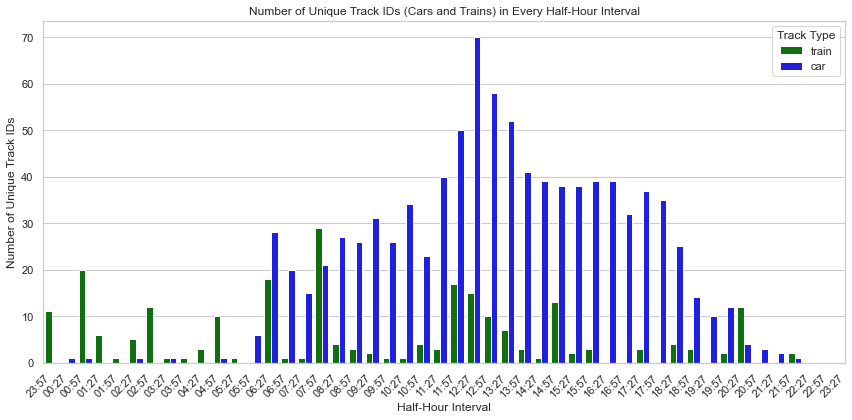

In [ ]:
import seaborn as sns
count_df = DF.groupby(['half_hour_interval', 'track_type'])['track ID'].nunique().reset_index()

# Set a seaborn style
sns.set_style("whitegrid")

# Plot the histogram with actual timestamps on the x-axis
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='half_hour_interval', y='track ID', hue='track_type', data=count_df, palette={'car': 'blue', 'train': 'green'})
ax.set_xlabel('Half-Hour Interval')
ax.set_ylabel('Number of Unique Track IDs')
ax.set_title('Number of Unique Track IDs (Cars and Trains) in Every Half-Hour Interval')

# Format x-axis labels to show timestamps
ax.set_xticks(range(0, half_hour_intervals))
ax.set_xticklabels([step.strftime('%H:%M') for step in half_hour_steps], rotation=45, ha='right')

plt.tight_layout()
plt.legend(title='Track Type', loc='upper right')
plt.show()